In [87]:
# Import libraries for this project
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint
from time import time
import logging
from sklearn.model_selection import train_test_split

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing

#SK-learn libraries for transformation and pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

#Seaboarn for EDA
import seaborn as sns
from sklearn.metrics import make_scorer

# Custom classes for this assignment
from kaggle import feature_engineering as fe

In [88]:
# Import our data
train_df = pd.read_csv('data/train.csv', index_col=0, infer_datetime_format=True)
train_df.index.name=None # Remove index name to remove confusing datetime column
train_df.index = pd.to_datetime(train_df.index) # Convert index to datetime
test_df = pd.read_csv('data/test.csv', index_col=0, infer_datetime_format=True)
test_df.index.name=None # Remove index name to remove confusing datetime column
test_df.index = pd.to_datetime(test_df.index) # Convert index to datetime

# W207 Final Project
## Bike Sharing Demand Kaggle Competition
Team Members: Zach Ingbretsen, Nicholas Chen, Keri Wheatley, and Rob Mulla

Kaggle Link: https://www.kaggle.com/c/bike-sharing-demand

## Business Understanding

A public bicycle-sharing system is a service in which bicycles are made available for a shared use to individuals on a very short-term basis. A bike-sharing system is comprised of a network of kiosks throughout a city which allows a participant to check-out a bike at one location and return it to a different location. Participants of a bike-sharing system can rent bikes on an as-needed basis and are charged for the duration of rental. Most programs require participants to register as users prior to usage. As of December 2016, roughly 1000 cities worldwide have bike-sharing systems.

Bike-sharing kiosks act as sensor networks for recording customer demand and usage patterns. For each bike rental, data is recorded for departure location, arrival location, duration of travel, and time elapsed. This data has valuable potential to researchers for studying mobility within a city. For this project, we explore customer mobility in relationship to these factors:
1.     Time of day
2.     Day type (workday, weekend, holiday, etc.)
3.     Season (Spring, Summer, Fall, Winter)
4.     Weather (clear, cloudy, rain, fog, snowfall, etc.)
5.     Temperature (actual, “feels like”)
6.     Humidity
7.     Windspeed

This project explores changes in demand given changes in weather and day. Our project delivers an exploratory data analysis as well as a machine-learning model to forecast bike rental demand. Bike rental demand is measured by total rental count which is further broken down into two rental types: rentals by registered users and rentals by non-registered users.

## Data Understanding

The data sources for this project are provided by kaggle. A train and test set and a example solution submission. https://www.kaggle.com/c/bike-sharing-demand

### What are the fields (columns)?

| Feature    | Description                                                                                                                                                                                                                                                                    |
|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| datetime   | hourlydate + timestamp                                                                                                                                                                                                                                                         |
| season     | **1** = spring, **2** = summer, **3** = fall, 4 = winter                                                                                                                                                                                                                                   |
| holiday    | whether the day is considered a holiday                                                                                                                                                                                                                                        |
| workingday | whether the day is neither a weekend nor holiday                                                                                                                                                                                                                               |
| weather    | **1:** Clear, Few clouds, Partly cloudy, Partly cloudy **2:** Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  **3:** Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  **4:** A Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| temp       | temperature in Celsius                                                                                                                                                                                                                                                         |
| atemp      | "feels like" temperature in Celsius                                                                                                                                                                                                                                            |
| humidity   | relative humidity                                                                                                                                                                                                                                                              |
| windspeed  | wind speed                                                                                                                                                                                                                                                                     |
| casual     | number of non-registered user rentals initiated                                                                                                                                                                                                                                |
| registered | number of registered user rentals initiated                                                                                                                                                                                                                                    |
| count      | number of total rentals                    

In [89]:
boolean_fields = ['season','holiday','workingday','weather']
other_fields = ['temp','atemp','humidity','windspeed','casual','registered','count']
other_fields_reduced = ['atemp','humidity','windspeed','count']

In [90]:
# Describe all of our numeric features
train_df[other_fields].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Exploratory Data Analysis

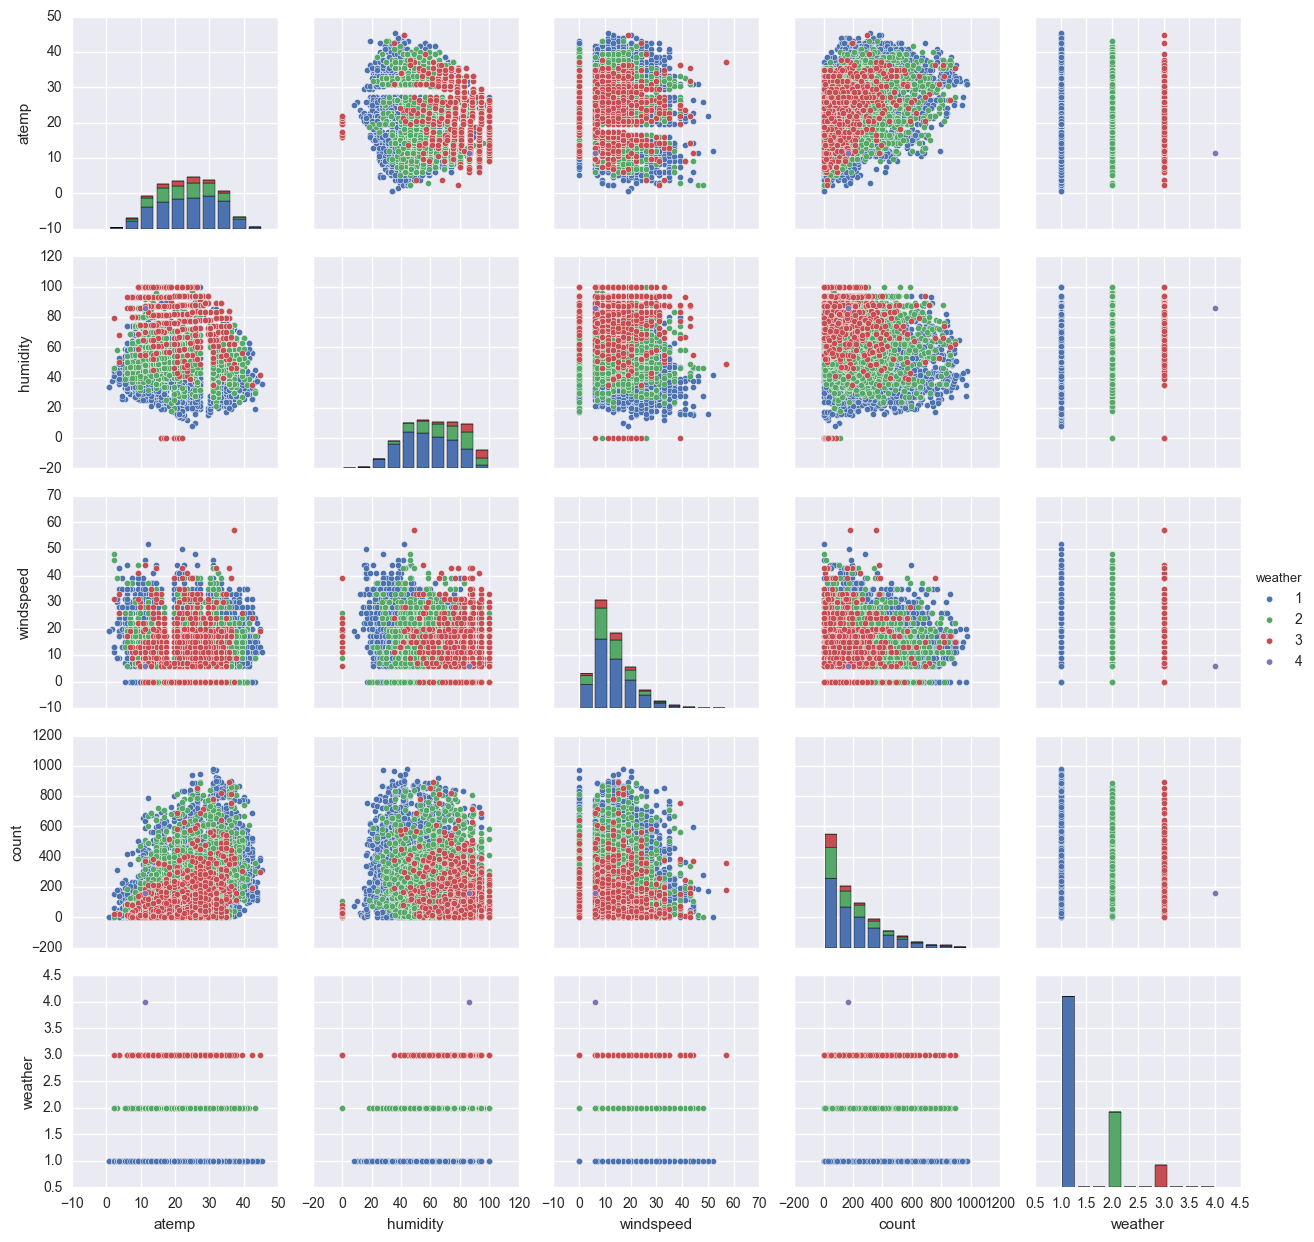

In [91]:
# Scatterplot all variables
scatplot_train = train_df[['atemp','humidity','windspeed','count','weather']]
sns.pairplot(scatplot_train, hue="weather");

In [92]:
## Need to hide this in code section

# Define some time based variables
def transform_variables(df):
    df['hour'] = df.index.hour
    df['weekday name'] = df.index.weekday_name
    df['weekday'] = df.index.weekday
    df['weekofyear'] = df.index.weekofyear
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['atempsq'] = df['atemp']**2
    df['tempsq'] = df['temp']**2
    return df
    
train_df_mod = transform_variables(train_df)

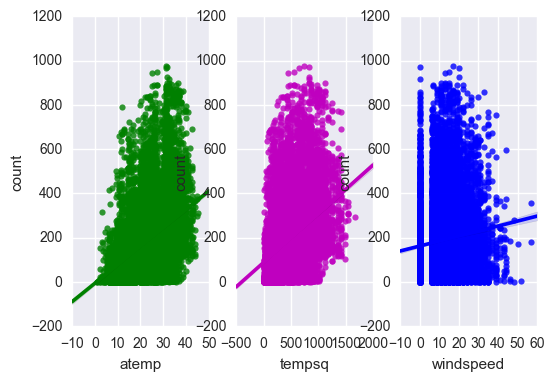

In [93]:
# Temp vs Riders Color of rider type
# NEED TO MAKE THE WIDTH DIFFERENT SO THIS LOOKS PRETTY
fig, axs = plt.subplots(ncols=3)
sns.regplot(x="atemp", y="count", color="g", data=train_df, ax=axs[0]);
sns.regplot(x="tempsq", y="count", color="m", data=train_df, ax=axs[1]);
sns.regplot(x="windspeed", y="count", color='b', data=train_df, ax=axs[2]);

In [94]:
# More plots not sure if we need
# sns.distplot(train_df.atemp, bins=20, kde=False, rug=True);
# sns.lmplot(x='temp', y='count', data=train_df, aspect=1.5, scatter_kws={'alpha':0.2})

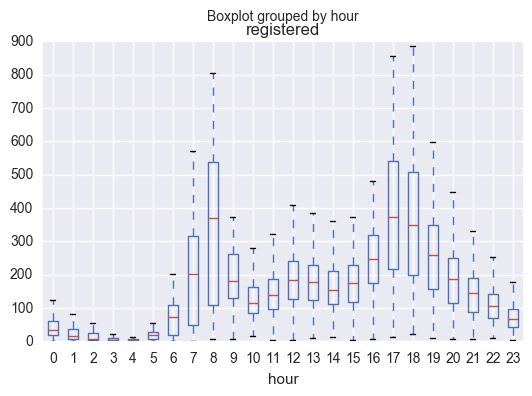

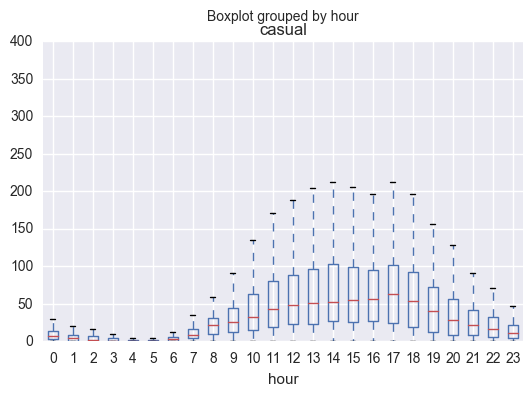

In [95]:
# Need to make things look clean. Plots side by side
#fig, axs = plt.subplots(ncols=2)
train_df.boxplot('registered','hour', )
train_df.boxplot('casual','hour', )

## Data Preparation

In [96]:
# Import data without using datetime as the index
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [97]:
# Log our inputs
train_df['casual'] = np.log(train_df['casual']+1)
train_df['registered'] = np.log(train_df['registered']+1)

In [98]:
# Define pipeline
categorical = ('season', 'holiday', 'workingday', )
# datetime isn't numerical, but needs to be in the numeric branch
numerical = ('datetime', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',)
pipeline = Pipeline([
    # process cat & num separately, then join back together
    ('union', FeatureUnion([ 
        ('categorical', Pipeline([
            ('select_cat', fe.SelectCols(cols = categorical)),
            ('onehot', OneHotEncoder()),    
        ])),    
        ('numerical', Pipeline([
            ('select_num', fe.SelectCols(cols = numerical)),
            ('date', fe.DateFormatter()),
            ('drop_datetime', fe.SelectCols(cols = ('datetime'), invert = True)),
            ('temp', fe.ProcessNumerical(cols_to_square = ('temp', 'atemp', 'humidity'))),
            # ('bad_weather', fe.BinarySplitter(col = 'weather', threshold = 2)),
            # ('filter', fe.PassFilter(col='atemp', lb = 15, replacement_style = 'mean'))
            ('scale', StandardScaler()),    
        ])),    
    ])),
    ('to_dense', preprocessing.FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('clf', GradientBoostingRegressor(n_estimators=100,random_state=2)),
])

In [99]:
#Helper function to calculate root mean squared error
def get_RMSE(actual_values, predicted_values):
    n = len(actual_values)
    RMSE = np.sqrt(np.sum(((np.log(predicted_values + 1) - np.log(actual_values + 1)) ** 2) / n))
    return RMSE

## Modeling

In [100]:
#Helper function to calculate root mean squared error
def get_RMSE(actual_values, predicted_values):
    n = len(actual_values)
    RMSE = np.sqrt(np.sum(((np.log(predicted_values + 1) - np.log(actual_values + 1)) ** 2) / n))
    return RMSE

#create custom scorer
RMSE_scorer = make_scorer(get_RMSE, greater_is_better = False)

In [101]:
##############################################
# Split into Dev and Train data and find best parameters
features = [c for c in train_df.columns if c not in ['count', 'casual', 'registered']]    
def train_dev_model_search(registered_or_casual,parameters):
    print("Performing grid search...")
    t0 = time()
    gs = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1, scoring=RMSE_scorer)
    gs.fit(train_data[features], train_data[registered_or_casual])
    print("Best parameters set:")
    best_param = gs.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_param[param_name]))
    predicted_y = gs.predict(dev_data[features])
    print "GridSearch RMSE " + str(gs.best_score_)
    rmse = get_RMSE(actual_values = dev_data[registered_or_casual], predicted_values = predicted_y)
    print "RMSE: ", str(rmse)
    print("Done in %0.3fs" % (time() - t0))
    print ""

In [102]:
# Split the data into train data and a dev data based on day of the month.
# This makes sense since the test data is days 19-30 of the month.
train_data = train_df[pd.DatetimeIndex(train_df['datetime']).day <= 16]
dev_data = train_df[pd.DatetimeIndex(train_df['datetime']).day > 16]

In [103]:
# Test for casual and registered separately
parameters = {
    'clf__n_estimators': (80,),
    'clf__learning_rate': (0.05,),
    'clf__max_depth': (10,),
    'clf__min_samples_leaf': (20,),
}

print "Casual rides"
train_dev_model_search('casual',parameters)

print "Registered rides"
train_dev_model_search('registered',parameters)

Casual rides
Performing grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.5s finished


Best parameters set:
	clf__learning_rate: 0.05
	clf__max_depth: 10
	clf__min_samples_leaf: 20
	clf__n_estimators: 80
GridSearch RMSE -0.242888807237
RMSE:  0.212232326045
Done in 19.337s

Registered rides
Performing grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.2s finished


Best parameters set:
	clf__learning_rate: 0.05
	clf__max_depth: 10
	clf__min_samples_leaf: 20
	clf__n_estimators: 80
GridSearch RMSE -0.123513854525
RMSE:  0.0873065898024
Done in 18.640s



## Evaluation

In [104]:
# Test for casual and registered separately
parameters = {
    'clf__n_estimators': (80,),
    'clf__learning_rate': (0.05,),
    'clf__max_depth': (10,),
    'clf__min_samples_leaf': (20,),
}

print "Casual rides"
train_dev_model_search('casual',parameters)

print "Registered rides"
train_dev_model_search('registered',parameters)

Casual rides
Performing grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.0s finished


Best parameters set:
	clf__learning_rate: 0.05
	clf__max_depth: 10
	clf__min_samples_leaf: 20
	clf__n_estimators: 80
GridSearch RMSE -0.242888807237
RMSE:  0.212232326045
Done in 19.752s

Registered rides
Performing grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.6s finished


Best parameters set:
	clf__learning_rate: 0.05
	clf__max_depth: 10
	clf__min_samples_leaf: 20
	clf__n_estimators: 80
GridSearch RMSE -0.123513854525
RMSE:  0.0873065898024
Done in 19.362s



In [105]:
##############################################
# Create full model using all train data

casual_best_param = {
    'clf__n_estimators': (80,),
    'clf__learning_rate': (0.05,),
    'clf__max_depth': (10,),
    'clf__min_samples_leaf': (20,),
}

registered_best_param = {
    'clf__n_estimators': (80,),
    'clf__learning_rate': (0.05,),
    'clf__max_depth': (10,),
    'clf__min_samples_leaf': (20,),
}

full_casual_gs = GridSearchCV(pipeline, casual_best_param, n_jobs=1, verbose=1, scoring='neg_mean_squared_error')
full_casual_gs.fit(train_df[features], train_df['casual'])
# np.exp converts back from log
full_casual_predicted_y = np.exp(full_casual_gs.predict(test_df[features]))-1

full_registered_gs = GridSearchCV(pipeline, registered_best_param, n_jobs=1, verbose=1, scoring='neg_mean_squared_error')
full_registered_gs.fit(train_df[features], train_df['registered'])
# np.exp converts back from log
full_registered_predicted_y = np.exp(full_registered_gs.predict(test_df[features]))-1

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.1s finished


## Deployment

In [106]:
test_df.set_index(pd.DatetimeIndex(test_df['datetime']), inplace=True)
test_df['count'] = (np.array([full_casual_predicted_y>0]*full_casual_predicted_y)).T+\
    (np.array([full_registered_predicted_y>0]*full_registered_predicted_y)).T
test_df[['count']].to_csv('data/combined_preds.csv')